## Data Wrangling

In [51]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from geopy.geocoders import Nominatim
import geopandas

### Create and Verify Database

In [3]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [4]:
ingest_create_athena_db_passed = False

In [5]:
# Set db name
database_name = "crops"

In [6]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [7]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [8]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [9]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default
2,sagemaker_featurestore


In [10]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [11]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"

### Add on for Views

In [52]:
from botocore.exceptions import ClientError

#Create a location for Views (Change this to Hunter's Bucket that is public)
s3_path_views = "s3://sagemaker-us-east-1-954372485966/views/"

# Create a new boto3 Athena client
client = boto3.client('athena')

In [53]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [54]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


### Convert to Parquet - Haven't got this to work, may be worth exploring to reduce costs

In [55]:
#Test Varaibles
parquet_table_test = 'parquet_test'
parquet_file_test = table_name_parquet + '.parquet'
print(f"parquet_table_test = '{parquet_table_test}'.")
print(f"parquet_file_test = '{parquet_file_test}'.")

parquet_table_test = 'parquet_test'.
parquet_file_test = 'merged_df_parquet.parquet'.


In [56]:
#statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}
#WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['item']) AS
#SELECT area,
#        item,
#        year,
#        production,
#        nitrogen,
#        phosphate,
#        potassium,
#        value,
#        avg_rain,
#        avg_temp,
#        total_value_usd  
# FROM {}.{}""".format(
#    database_name, table_name_parquet, s3_path_parquet, database_name, table_name_csv
#)

In [57]:
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)
print(f"Initial SQL Table = '{statement}'.")

df_parquet = pd.read_sql(statement, conn)
print('First Read SQL into DF \n')
print(df_parquet.head(5))

df_parquet.to_parquet(parquet_file_test)
print('DF Conversion to Parquet \n')
print(df_parquet.head(5))

Initial SQL Table = 'SELECT * FROM crops.merged_df'.
First Read SQL into DF 

      area                                item  year  production  nitrogen  \
0  Albania                              Apples  1991     10000.0   22300.0   
1  Albania                            Apricots  1991      1200.0   22300.0   
2  Albania                              Barley  1991      3323.0   22300.0   
3  Albania                          Beans  dry  1991     12844.0   22300.0   
4  Albania  Broad beans and horse beans  green  1991         0.0   22300.0   

   phosphate  potassium  value  avg_rain  avg_temp  total_value_usd  
0     7700.0     1300.0    NaN    1485.0     15.36              NaN  
1     7700.0     1300.0    NaN    1485.0     15.36              NaN  
2     7700.0     1300.0    NaN    1485.0     15.36              NaN  
3     7700.0     1300.0    NaN    1485.0     15.36              NaN  
4     7700.0     1300.0    NaN    1485.0     15.36              NaN  
DF Conversion to Parquet 

      

In [58]:
print(f"Uploading Parquet File '{parquet_file_test}'")
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, parquet_file_test).upload_file(parquet_file_test)

# Create a boto3 S3 client
s3_client = boto3.client('s3')

# Check if the Parquet file exists in the S3 bucket
try:
    s3_client.head_object(Bucket=bucket, Key=parquet_file_test)
    print(f"The Parquet file '{parquet_file_test}' exists in the S3 bucket '{bucket}'.")
except:
    print(f"The Parquet file '{parquet_file_test}' does not exist in the S3 bucket '{bucket}'.")

Uploading Parquet File 'merged_df_parquet.parquet'
The Parquet file 'merged_df_parquet.parquet' exists in the S3 bucket 'sagemaker-us-east-1-954372485966'.


In [30]:
parquet_table_statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = 's3://{}/')
AS SELECT * FROM {}.{}""".format(database_name, parquet_table_test, s3_path_parquet, database_name, table_name_csv)
# cursor.execute(f"CREATE TABLE <your-new-athena-sql-table> WITH (format = 'PARQUET', external_location = 's3://<your-s3-bucket>/') AS SELECT * FROM <your-athena-sql-table>")

# cursor.execute(statement)
print(f"Parquet Table Creation = '{parquet_table_statement}'.")
df_parquetFiletoSql_createTable = pd.read_sql(parquet_table_statement, conn)

df_parquetFiletoSql_statement = """SELECT * FROM {}.{}""".format(
    database_name, parquet_table_test)
print(f"Parquet Table Select Statement = '{df_parquetFiletoSql_statement}'.")
df_parquetFiletoSql_readTable = pd.read_sql(df_parquetFiletoSql_statement, conn)
print(df_parquetFiletoSql_readTable.head(5))

Parquet Table Creation = 'CREATE TABLE IF NOT EXISTS crops.parquet_test
WITH (format = 'PARQUET', external_location = 's3://s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet//')
AS SELECT * FROM crops.merged_df'.


DatabaseError: Execution failed on sql: CREATE TABLE IF NOT EXISTS crops.parquet_test
WITH (format = 'PARQUET', external_location = 's3://s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet//')
AS SELECT * FROM crops.merged_df
[ErrorCode: INTERNAL_ERROR_QUERY_ENGINE] Amazon Athena experienced an internal error while executing this query. Please contact AWS support for further assistance. You will not be charged for this query. We apologize for the inconvenience. You may need to manually clean the data at location 's3://sagemaker-us-east-1-954372485966/athena/staging/tables/5408348b-f359-480e-b37f-6d9a210573bc' before retrying. Athena will not delete data in your account.
unable to rollback

# Exploratory Data Analysis

In [59]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
1,Albania,Apricots,1991,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
2,Albania,Barley,1991,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
3,Albania,Beans dry,1991,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
4,Albania,Broad beans and horse beans green,1991,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN


In [60]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 113454 rows in the data frame and 11 columns


## Adding in Geographic Data
Since we're using location as a predictor, we'll need to grab the coordinates of each country. There are also regions that we'll need to delete

In [61]:
# Functions to find coordinates
geolocater = Nominatim(user_agent="geoapiExercise")
def geolocate_lat(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.latitude)
    except:
        return np.nan
    
def geolocate_long(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.longitude)
    except:
        return np.nan

In [62]:
# Get the coordinates and build df for them
countries = df['area'].unique()
countries = pd.Series(countries)

latitudes = countries.apply(geolocate_lat)
longitudes = countries.apply(geolocate_long)

coord = pd.DataFrame(list(zip(countries, latitudes, longitudes)),
             columns=['area', 'lat', 'long'])

In [63]:
# Merge our data
df = pd.merge(df, coord, left_on=['area'], right_on=['area'], how="inner")
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
0,Albania,Apples,1991,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
1,Albania,Apricots,1991,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
2,Albania,Barley,1991,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
3,Albania,Beans dry,1991,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962
4,Albania,Broad beans and horse beans green,1991,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN,41.000028,19.999962


## NA Analysis

In [64]:
nan_count = df.isna().sum()
print(nan_count)

area                   0
item                   0
year                   0
production          2570
nitrogen            2149
phosphate           4453
potassium           5433
value              40675
avg_rain               0
avg_temp               0
total_value_usd    40918
lat                    0
long                   0
dtype: int64


The large amount of NAs in total_value_usd appears to be from value. Likely a country not reporting in USD or based on the year. Either one would be fairly hard to get the correct value as we would need to look up the conversion rates for every country at the specific times.

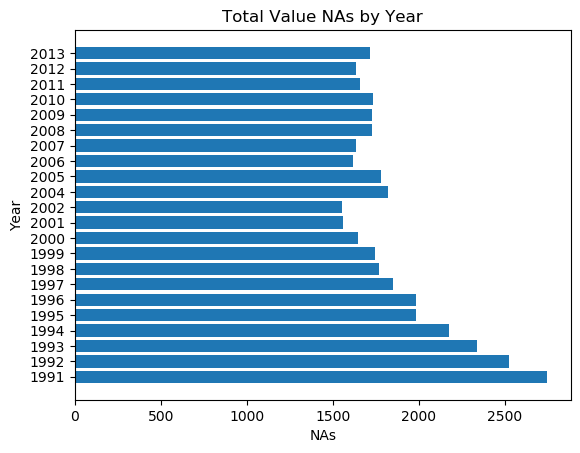

In [65]:
# By Year
na_year = df.total_value_usd.isnull().groupby(df['year']).sum().astype(int).reset_index(name="count")
na_year['year'] = na_year['year'].astype(object)

bars = na_year['year']
height = na_year['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Year")
plt.ylabel("Year")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

### Creating a View for NA By Year in Athena

In [76]:

# Define the SQL statement to create the view
years_ViewName = 'TotalValueNAByYear'
TotalValueNAByYear_statment = """ CREATE OR REPLACE VIEW {}.{} AS
SELECT year, SUM(CASE WHEN total_value_usd IS NULL then 1 ELSE 0 END) AS Total_Value_USD_Nulls
FROM {}.{}
GROUP BY year
ORDER BY 2 desc
""".format(database_name, years_ViewName, database_name, table_name_csv) 

# Execute the query to create the view
try:
    response = client.start_query_execution(
        QueryString=TotalValueNAByYear_statment,
        QueryExecutionContext={
            'Database': database_name
        },
        ResultConfiguration={
            'OutputLocation': s3_path_views
        }
    )
    print('View created successfully')
except ClientError as e:
    print('Error creating view: {}'.format(e))

View created successfully


In [77]:
yearsNA_statement = """SELECT * FROM {}.{}""".format(database_name, years_ViewName)
print(yearsNA_statement)
df_yearsNA = pd.read_sql(yearsNA_statement, conn)
df_yearsNA

SELECT * FROM crops.TotalValueNAByYear


,year,Total_Value_USD_Nulls
0,1991,2745
1,1992,2526
2,1993,2339
3,1994,2177
4,1996,1985
5,1995,1980
6,1997,1851
7,2004,1822
8,2005,1777
9,1998,1768


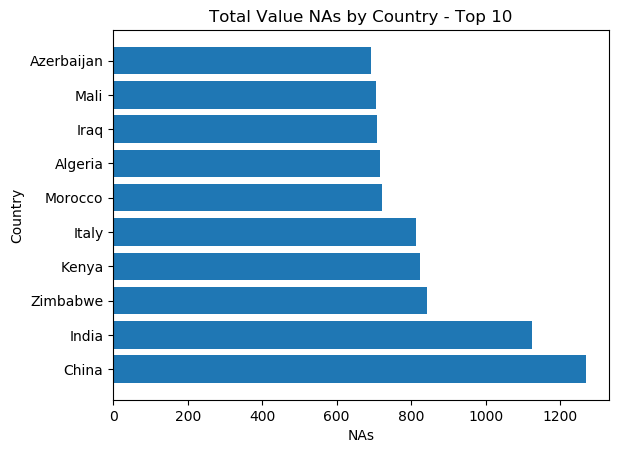

In [68]:
# By Country
na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Country - Top 10")
plt.ylabel("Country")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

### View for NA By Country

In [78]:
# Define the SQL statement to create the view
country_ViewName = 'TotalValueNAByCountry'
TotalValueNAByCountry_statment = """ CREATE OR REPLACE VIEW {}.{} AS
SELECT area as Country, SUM(CASE WHEN total_value_usd IS NULL then 1 ELSE 0 END) AS Total_Value_USD_Nulls
FROM {}.{}
GROUP BY area
ORDER BY 2 desc
""".format(database_name, country_ViewName, database_name, table_name_csv) 

# Execute the query to create the view
try:
    response = client.start_query_execution(
        QueryString=TotalValueNAByCountry_statment,
        QueryExecutionContext={
            'Database': database_name
        },
        ResultConfiguration={
            'OutputLocation': s3_path_views
        }
    )
    print('View created successfully')
except ClientError as e:
    print('Error creating view: {}'.format(e))

View created successfully


In [79]:
countryNA_statement = """SELECT * FROM {}.{}""".format(database_name, country_ViewName)
print(countryNA_statement)
df_countryNA = pd.read_sql(countryNA_statement, conn)
df_countryNA

SELECT * FROM crops.TotalValueNAByCountry


,Country,Total_Value_USD_Nulls
0,China,1268
1,India,1125
2,Zimbabwe,843
3,Kenya,825
4,Italy,812
...,...,...
98,Denmark,99
99,Estonia,87
100,Poland,78
101,Mongolia,54


It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [28]:
df_nona = df.dropna()
df_nona_india = df_nona[df_nona['area'] == "India"]
df_india = df[df['area'] == "India"]

print("India loses", df_india.shape[0] - df_nona_india.shape[0], "observations when we take out NAs leaving us with", df_nona_india.shape[0], "observations left for the country")

India loses 1125 observations when we take out NAs leaving us with 437 observations left for the country


### Final clean before modeling 
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those. We also should not need production, value, or year for our final modeling (not doing time series) so we'll create another modeling dataframe here.

In [29]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            173
phosphate          1376
potassium          1615
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
lat                   0
long                  0
dtype: int64


In [ ]:
df_model = df_clean.drop(columns = ['year', 'production', 'value'], axis = 1)

## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

In [ ]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

Correlation Matrix for Numeric Features

In [ ]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_geo = pd.merge(df, world, how="inner", left_on=['area'], right_on=['name']).reset_index()
world_geo.head()

### Highest Ag Value 1991-2013

In [ ]:
val_country = world_geo.groupby(by="area")["total_value_usd"].sum()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,val_country, geos)),
                           columns=['country', 'value', 'geometry'])
val_country.head()

gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

gdf_value.head()

In [ ]:
gdf_value['value'] = gdf_value[['value']]/1_000_000_000_000

In [ ]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_value.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})
plt.show()



### Avg. Temperatures

In [ ]:
# Taking mean of mean should be okay since our sample sizes are the same
temps = world_geo.groupby(by="area")["avg_temp"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,temps, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

In [ ]:
# Taking mean of mean should be okay since our sample sizes are the same
rain = world_geo.groupby(by="area")["avg_rain"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,rain, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [ ]:
nit = world_geo.groupby(by="area")["nitrogen"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,nit, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)



In [ ]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

In [ ]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Phosphate

In [ ]:
phos = world_geo.groupby(by="area")["phosphate"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,phos, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_phos = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [ ]:
gdf_phos['value'] = gdf_phos[['value']]/1_000_000

In [ ]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_phos.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Phosphate for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Potassium

In [ ]:
pot= world_geo.groupby(by="area")["potassium"].mean()
geos = world_geo['geometry'].unique()

val_country = pd.DataFrame(list(zip(countries,pot, geos)),
                           columns=['country', 'value', 'geometry'])

gdf_pot = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [ ]:
gdf_pot['value'] = gdf_pot[['value']]/1_000_000

In [ ]:
plt.clf()

base = world.plot(color = "white", edgecolor = 'black')

gdf_pot.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Potassium for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

## Categorical Anaylsis

#### "Area" and "item" are the only categorical variables

In [ ]:
cat_df = pd.DataFrame(df, columns =['area', 'item'])
cat_df.head()

### "area" EDA:

In [ ]:
#Finding the count of countries that are in the Area column:

print ("There are", cat_df['area'].nunique(), "different areas/countries in the dataset")

In [ ]:
#examining unique values of countries that are in the dataset
cat_df['area'].unique()


#### Might be useful to create a reference dataframe/table for the areas column:

In [ ]:
countries_df = pd.DataFrame(cat_df['area'].unique())

countries_df.head()

In [ ]:
#frequency of each country: 
cat_df['area'].value_counts().head(10).plot(kind='barh', figsize=(20,10), title= 'Top 10 Countries With Most Rows of Data', xlabel='Count', ylabel='Country', color = 'teal')
plt.show()

#### Countries with most rows of data include India, Mexico, Brazil & Australia

In [ ]:
#Total production based on country
p_country = df.production.groupby(df['area']).sum().astype(int).reset_index(name="sum")
p_country = p_country.sort_values(by=['sum'], ascending=False).head(10)

p_country

p_country.plot(kind='barh', figsize=(20,10), title= 'Top 10 Producing Countries', x=('area'), y = ('sum'), xlabel='Production Count', ylabel='Country', color = 'teal')
plt.show()


#### countries with most production are India, Brazil, Indonesia, and Mexico

In [ ]:
#Total value usd based on country
usd_country = df.total_value_usd.groupby(df['area']).sum().astype(int).reset_index(name="sum")
usd_country = usd_country.sort_values(by=['sum'], ascending=False).head(10)

usd_country.head()

usd_country.plot(kind='barh', figsize=(20,10), title= 'Top 10 Countries With Most Total Value', x=('area'), y = ('sum'), xlabel='Total Value (USD)', ylabel='Country', color = 'teal')
plt.show()


#### Countries with highest total value USD include India, Brazil, Japan, Mexico. 

### "Item" EDA

In [ ]:
#Finding the count of Items that are in the Item column:

print ("There are", cat_df['item'].nunique(), "different produce items in the dataset")

In [ ]:
#examining unique to view different item types that are in the dataset
items = pd.DataFrame(cat_df['item'].unique())
items.head()

In [ ]:
#frequency of each item: 
cat_df['item'].value_counts().head(10).plot(kind='barh', figsize=(20,10), title= 'Top 10 Items With Most Rows of Data', xlabel='Count', ylabel='Item', color = 'teal')
plt.show()

#### Top items with most rows of data are hen eggs in shell fresh, raw milk of acttle, potatoes, tomatoes, maize corn, etc. 

In [ ]:
#Total production based on country
I_country = df.production.groupby(df['item']).sum().astype(int).reset_index(name="sum")
I_country = I_country.sort_values(by=['sum'], ascending=False).head(10)

I_country.plot(kind='barh', figsize=(20,10), title= 'Top 10 Produced Items', x=('item'), y = ('sum'), xlabel='Production Count', ylabel='Item', color = 'teal')
plt.show()

#### Top produced items include sugar cane, rice, hen eggs in shell fresh & wheat. 

In [ ]:
#Total value usd based on Item
usd_item = df.total_value_usd.groupby(df['item']).sum().astype(int).reset_index(name="sum")
usd_item = usd_item.sort_values(by=['sum'], ascending=False).head(10)


usd_item.plot(kind='barh', figsize=(20,10), title= 'Top 10 Items With Most Total Value', x=('item'), y = ('sum'), xlabel='Total Value (USD)', ylabel='Items', color = 'teal')
plt.show()

#### Items that have highest total value USD include hen eggs in shell fresh, rice, wheat, raw milk of cattle, etc. 